In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 5 2025

@author: Yaning
"""


import torch.optim as optim
import random
import torch
import torch.nn as nn
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import numpy as np

In [36]:
# Set the device ("mps" if you're using an M series mac):
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/yaning/Documents/python_env/llm/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model_name = "meta-llama/Meta-Llama-3.1-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name)

In [4]:
with open('/home/yaning/Documents/LLM/skip_gram/winnetou_h.txt', 'r') as file:
    h_text = file.read()

with open('/home/yaning/Documents/LLM/skip_gram/winnetou_s.txt', 'r') as file:
    s_text = file.read()

In [5]:
h_text = h_text.lower()
s_text = s_text.lower()

In [404]:
s_text = "Haid geh ich in die Schdadt, um paar Eingaufn zu machn. Dann treffsch mich mit Feiern im Café un genießn e heeßn Gaffee. Es is'n schieener Tach, un ich freu mich offn Oobnd."
h_text = "Heute gehe ich in die Stadt, um ein paar Einkäufe zu machen. Danach treffe ich mich mit Freunden im Café und genieße einen heißen Kaffee. Es ist ein schöner Tag, und ich freue mich auf den Abend."

Generate Voaculary

In [ ]:
# generate vocabulary dictionary
vocab_text = (s_text+h_text).lower()
vocab_text = re.findall(r'\b[\wäöüßéèàôûç]+\b', vocab_text)

vocab = set(vocab_text)

In [15]:
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

Generate Training data

In [16]:
train_h = re.sub(r'[.,\n]', " ", h_text)
train_s = re.sub(r'[.,\n]', " ", s_text)

In [17]:
train_h = re.findall(r'\b[\wäöüßéèàôûç]+\b', train_h)
train_s = re.findall(r'\b[\wäöüßéèàôûç]+\b', train_s)

In [18]:
window_size = 10

The pairs generating is important, which ones do you want to put in the same context

In [20]:
# transform them to indx
train_h_indx = []
for i in train_h:
    train_h_indx.append(word_to_index[i])

train_s_indx = []
for i in train_s:
    train_s_indx.append(word_to_index[i])

In [21]:
pad_index = len(vocab)

In [22]:
index_to_word[pad_index] = '[PAD]'
word_to_index['[PAD]'] = pad_index

In [27]:
acc_h = train_h_indx.copy()

In [ ]:
acc_s = []
ratio = len(train_s_indx)/len(train_h_indx)
for i in range(len(acc_h)):

    center = i*ratio
    chunk_begin = round(center - window_size/2)
    chunk_end = round(center + window_size/2)
    if chunk_end - chunk_begin != window_size:
        random_number = random.randint(0, 1)
        if random_number == 0:
            chunk_begin = chunk_begin+1
        else:
            chunk_end = chunk_end-1
    
    if chunk_begin < 0:
        chunk_begin = 0
    if chunk_end > len(train_s_indx)-1:
        chunk_end = len(train_s_indx)-1
    
    temp = train_s_indx[chunk_begin:chunk_end]
    while len(temp) != window_size:
        temp.append(pad_index)
    acc_s.append(temp)

In [51]:
combined = []
for i in range(len(acc_h)):
    combined.append([acc_h[i]] + acc_s[i])

In [30]:
train_data = list(zip(acc_h, acc_s))

In [70]:
class Word2VecSkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecSkipGram, self).__init__()
        self.input_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output_embedding = nn.Embedding(vocab_size, embedding_dim)
    
    def forward(self, center_word, context_word):
        # Get embeddings for center and context words
        center_embedding = self.input_embedding(center_word)  # Shape: (batch_size, embedding_dim)
        context_embedding = self.output_embedding(context_word)  # Shape: (batch_size, embedding_dim)
        
        # Compute dot product (similarity score)
        similarity = torch.mul(center_embedding, context_embedding).sum(dim=1)
        # similarity = torch.mul(center_embedding, context_embedding)
        # sum_similarity = torch.sum(similarity)
        return similarity

embedding_dim = 50
vocab_size = len(word_to_index)

model = Word2VecSkipGram(vocab_size=vocab_size, embedding_dim=embedding_dim).to(device)
print(model)


Word2VecSkipGram(
  (input_embedding): Embedding(10837, 50)
  (output_embedding): Embedding(10837, 50)
)


In [76]:
# Define the loss function
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super(NegativeSamplingLoss, self).__init__()
        self.log_sigmoid = nn.LogSigmoid()

    def forward(self, positive_similarity, negative_similarity):
        pos_loss = self.log_sigmoid(positive_similarity).mean()
        neg_loss = self.log_sigmoid(-negative_similarity).mean()
        return - (pos_loss + neg_loss)

learning_rate = 0.001
num_epochs = 10

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = NegativeSamplingLoss()

def get_negative_samples(vocab_size, batch_size, num_samples):
    return torch.randint(0, vocab_size, (batch_size, num_samples))
    

In [80]:
losses = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    random.shuffle(train_data)  # Shuffle pairs each epoch

    for i in range(len(train_data)):
        # center_idx = torch.tensor([word_to_index[center_word]], dtype=torch.long)
        # context_idx = torch.tensor([word_to_index[context_word]], dtype=torch.long)
        # print(context_idx[1])
        center_idx = train_data[i,0]
        context_idx = train_data[i, 1:]
        center_idx = torch.tensor(center_idx)
        context_idx = torch.tensor(context_idx)
        # print(center_idx)
        # print(context_idx)
        positive_similarity = model(center_idx, context_idx)
        
        # Negative sampling
        negative_samples = get_negative_samples(vocab_size, 1, window_size).to(device)
        negative_similarity = model(center_idx, negative_samples.view(-1))
        
        # Calculate loss and update model
        loss = criterion(positive_similarity, negative_similarity)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    losses.append(total_loss)
    
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(pairs):.4f}")

  0%|                                                                                                                      | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_271924/504858458.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  center_idx = torch.tensor(center_idx)
/tmp/ipykernel_271924/504858458.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context_idx = torch.tensor(context_idx)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:17<00:00, 31.73s/it]


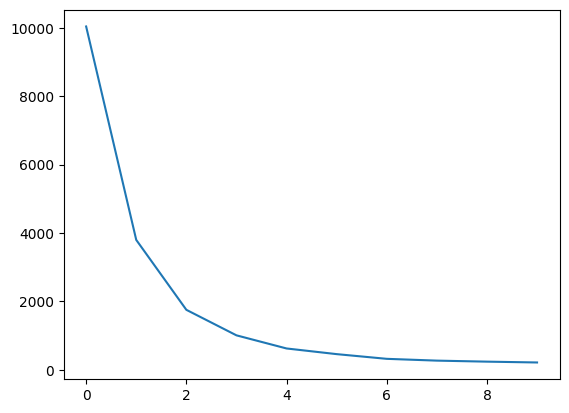

In [81]:
plt.plot(losses)

In [ ]:
words_to_visualize = ['ich', 'schöne', 'nestern', 'abzuzäumen']
words_to_visualize = ['schdadt', 'stadt', 'heute', 'haid', 'ich']
word_indices = torch.tensor([word_to_index[word] for word in words_to_visualize], dtype=torch.long).cpu().tolist()
word_vectors = [model.input_embedding(torch.tensor(word_idx).to(device)).cpu().detach().numpy()  for word_idx in word_indices]

# Reduce dimensionality
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

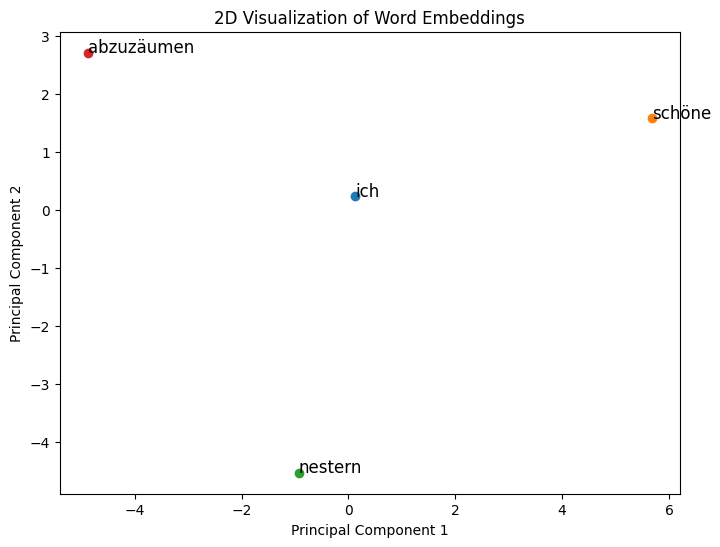

In [102]:
# Plot the word vectors
plt.figure(figsize=(8, 6))
for i, word in enumerate(words_to_visualize):
    plt.scatter(reduced_vectors[i][0], reduced_vectors[i][1])
    plt.annotate(word, xy=(reduced_vectors[i][0], reduced_vectors[i][1]), fontsize=12)
plt.title("2D Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig("embedding.png", dpi=300)
plt.show()


In [103]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [128]:
word_idx = word_to_index["fraßen"]

In [129]:
target_embedding = model.input_embedding(torch.tensor(word_idx).to(device)).cpu().detach().numpy()

In [130]:
all_embeddings = model.input_embedding.weight.data.cpu().detach().numpy()

In [131]:
max_similarity = -1
for idx, embedding in enumerate(all_embeddings):
    if idx == word_idx:  # Skip the target embedding
        continue
    similarity = cosine_similarity(target_embedding, embedding)
    if similarity > max_similarity:
        max_similarity = similarity
        closest_word_idx = idx

In [132]:
index_to_word[closest_word_idx]

'lache'